## PCA with Undercomplete Linear Autoencoder

In [2]:
import tensorflow as tf

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2, input_shape=(3,))])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(optimizer=optimizer, loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
# dataset
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 세트 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # 약간 이동

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


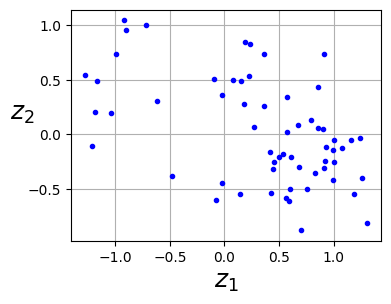

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Multi-layer Encoder

### Multi-layer Encoder

In [7]:
# Dataset load
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss='mse', optimizer='nadam')
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0353 - val_loss: 0.0186
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0145 - val_loss: 0.0147
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0143 - val_loss: 0.0145
Epoch 12/20
1719/1719 ━━━━━━━━

### Reconstruction Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


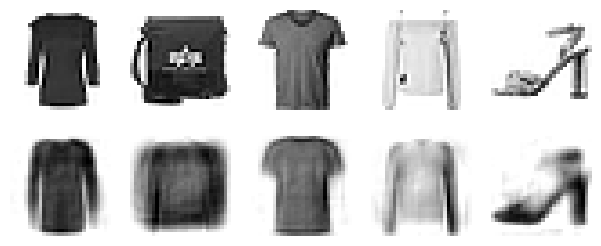

In [10]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis('off')
plot_reconstructions(stacked_ae)
plt.show()

### Fashion MNIST Dataset Visualization

In [11]:
from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init='pca', learning_rate='auto', random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


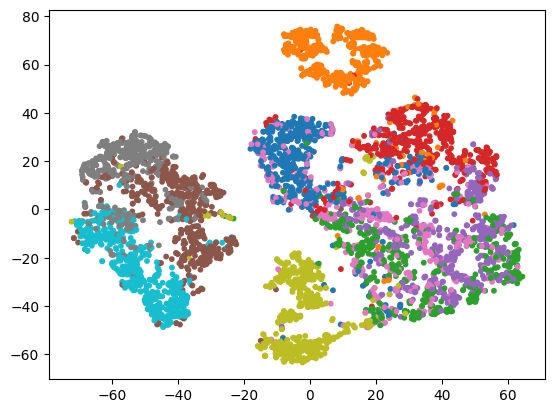

In [12]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.show()

### Tying Weights

In [37]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        input_dim = self.dense.kernel.shape[0]
        self.biases = self.add_weight(name="bias",
                                      shape=(input_dim,),
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.kernel, transpose_b=True)
        return self.activation(Z + self.biases)

In [38]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])